In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates
import os
import yaml
import numpy as np
import copy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

home       = os.path.expanduser("~")
yaml_path  = os.path.join(home, 'dirpaths.yaml')
data_dir   = yaml.safe_load(open(yaml_path))['CPOM2_PATH']

fname      = 'era5.vars.nc'
fpath      = os.path.join(data_dir, 'jules', 'output', 'jules_vn7.9','era5_gridded_meltlake', fname)
output     = nc.Dataset(fpath, 'r')
start_time = pd.Timestamp('1979-01-01 00:00')

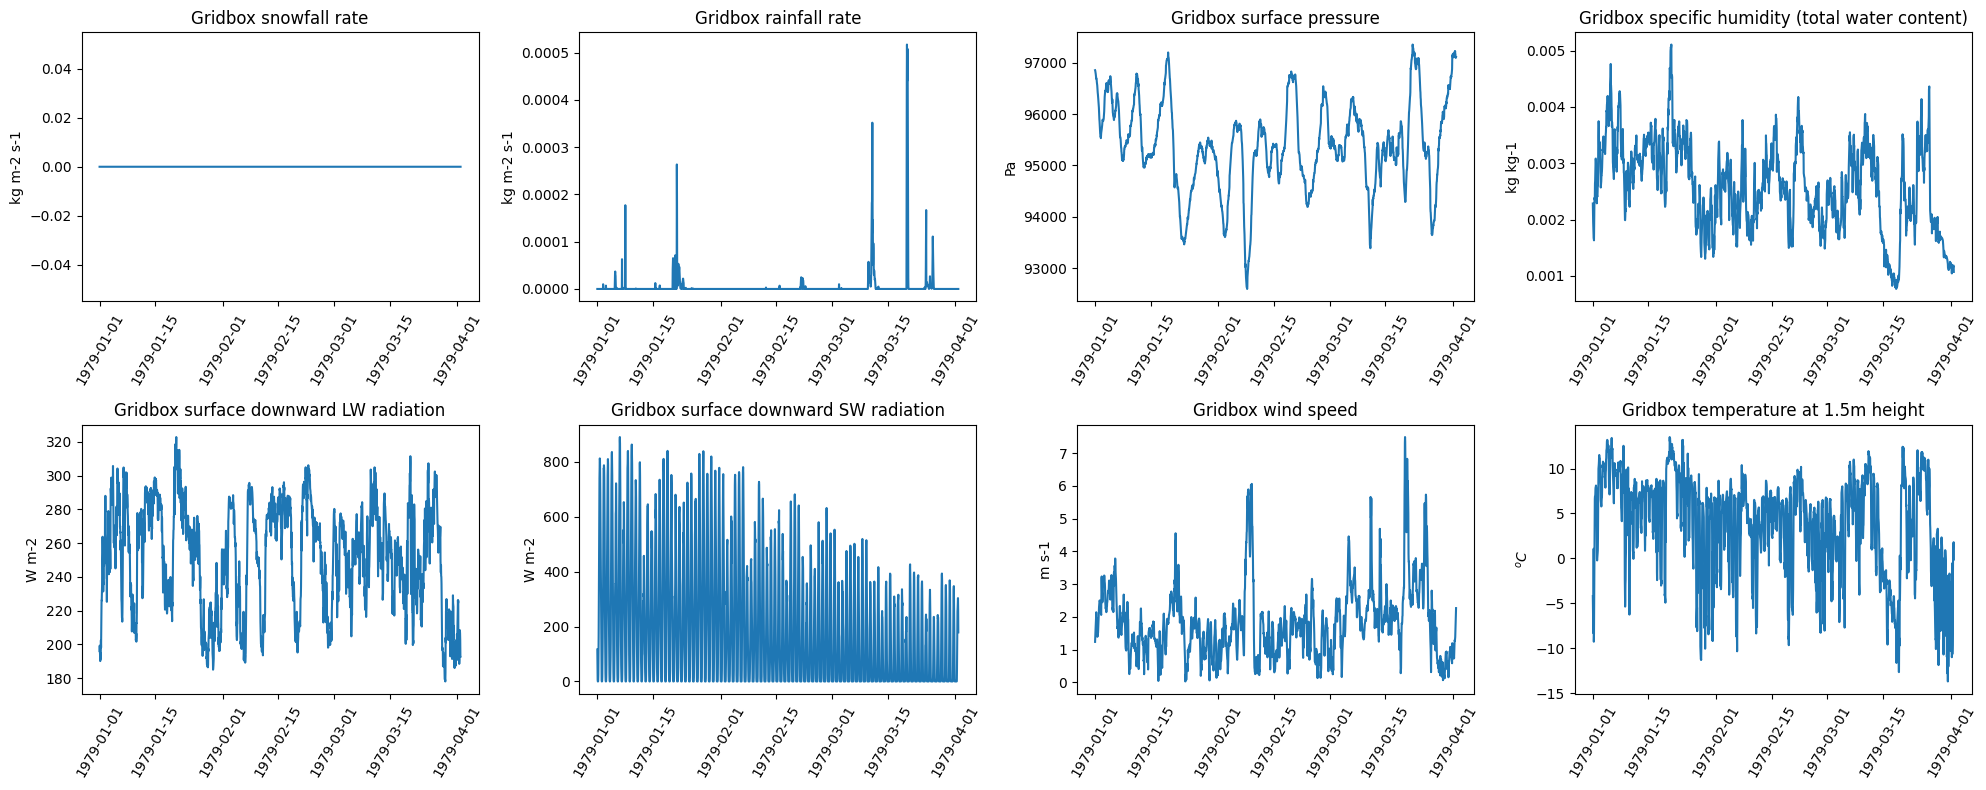

In [2]:
# plot all vars with dimensions (time, y, x)
#gb_vars = [v for v in output.variables if output.variables[v].dimensions == ('time', 'y', 'x')]
gb_vars = ['snowfall','rainfall','pstar','qw1','lw_down','sw_down','wind','t1p5m_gb']

fig, axes = plt.subplots(-(-len(gb_vars) // 4), 4, figsize=(20, 4 * ((len(gb_vars) + 3) // 4)))
axes = axes.flat

for ax, v in zip(axes, gb_vars):
    data = output[v][1:-1, 0, 0]
    

    units = getattr(output[v], 'units', '')    
    time = pd.date_range(start=start_time, periods=len(data), freq='h')

    if v == 't1p5m_gb':
        data -= 273.15
        units = '$^oC$'
        
    ax.plot(time, data)
    ax.set_title(getattr(output[v], 'long_name', v))
    ax.set_ylabel(units)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=360))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

    
    ax.tick_params(axis='x', rotation=60)

for ax in axes[len(gb_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [3]:
nsnow = output['nsnow'][:, 8, 0, 0]
print(nsnow)

[90. 90. 90. ... 84. 84. 84.]


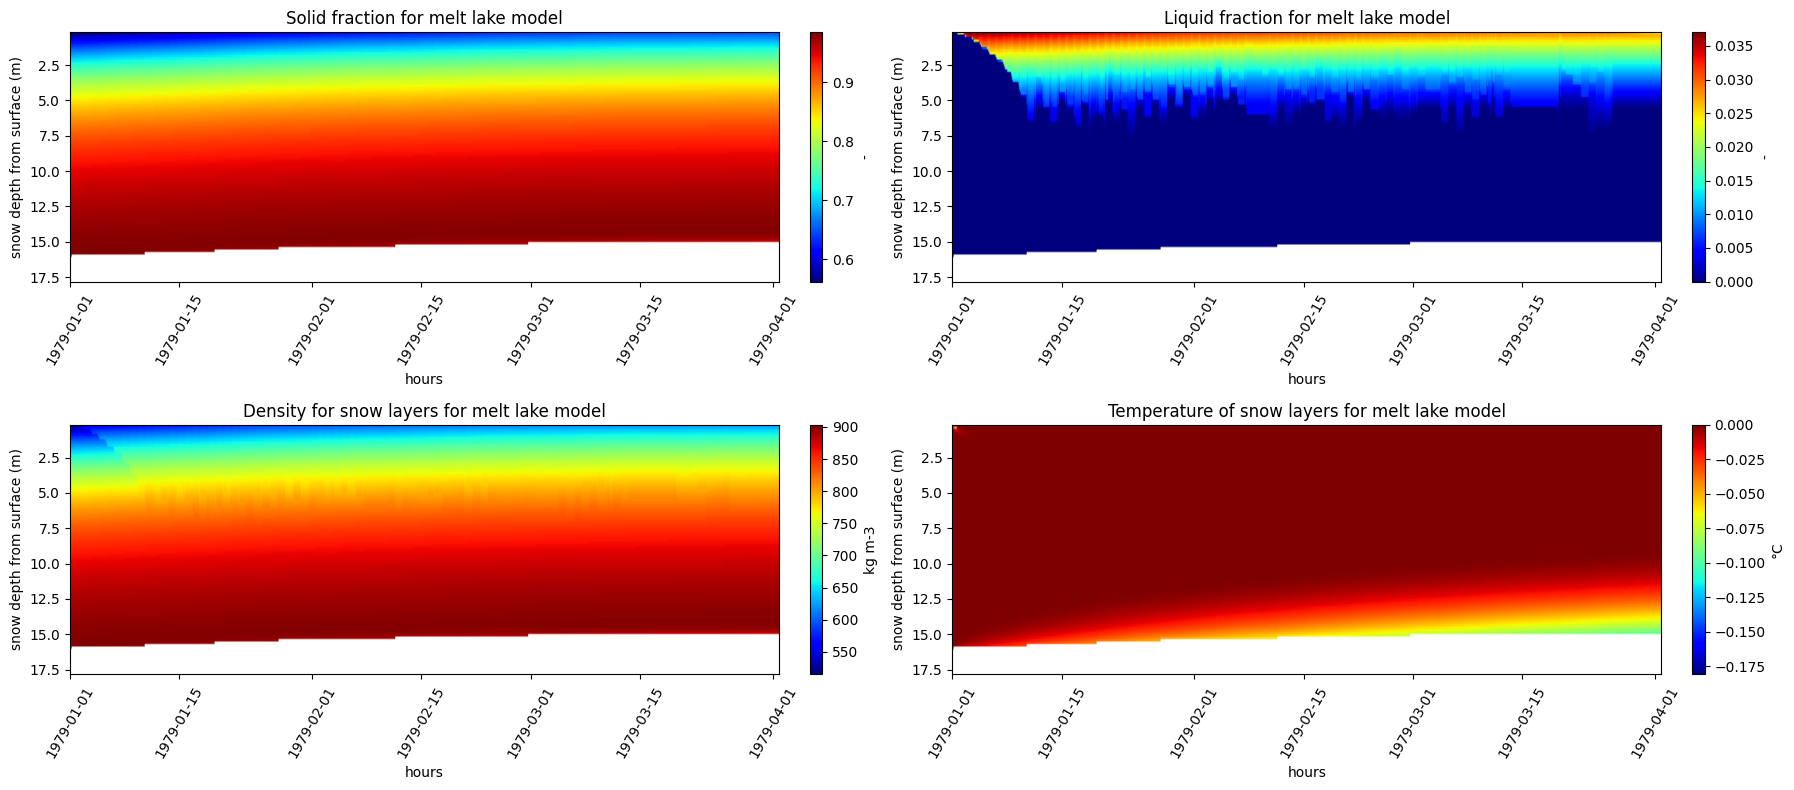

In [10]:
depth = np.arange(18, 0, -0.18)  

#snow_vars = [v for v in output.variables
#             if output.variables[v].dimensions == ('time', 'snow_ml', 'tile', 'y', 'x')]

snow_vars = ['sfrac_ml', 'lfrac_ml','rho_snow_ml','tsnow_ml']

fig, axes = plt.subplots(2, 2, figsize=(18, 8))
axes = axes.flat

nsnow = output['nsnow'][:, 8, 0, 0].astype(int)

#cmap = copy.copy(plt.cm.get_cmap('jet'))
cmap = copy.copy(plt.colormaps['jet'])

cmap.set_bad('white')

time_num = mdates.date2num(time)

for ax, v in zip(axes, snow_vars):

    data = np.array(output[v][:,:, 8, 0, 0])
    units = getattr(output[v], 'units', '')
    if v == 'tsnow_ml':
        data -= 273.15
        units = '°C'
    
    #time = pd.date_range(start=start_time, periods=len(data), freq='h')
    
    
    # mask inactive levels
    for t, n_active in enumerate(nsnow):
        if n_active < data.shape[1]:
            data[t, n_active:] = np.nan
    
    #im = ax.imshow(data.T, aspect='auto', origin='lower', cmap=cmap,extent=[0, data.shape[0], depth[-1], depth[0]])
    im = ax.imshow(data.T, aspect='auto', origin='lower', cmap=cmap, extent=[time_num[0], time_num[-1], depth[-1], depth[1]])
            
    ax.set(title=getattr(output[v], 'long_name', v), ylabel='snow depth from surface (m)', xlabel='hours')
    plt.colorbar(im, ax=ax, label=units, fraction=0.046, pad=0.04)
    ax.invert_yaxis() 
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=60)
    #ax.set_ylim(0, 10)

for ax in axes[len(snow_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()


In [24]:
#end of run values 
#nsnow = output.variables['nsnow'][:,8,0,0]
#print('-------------------- nsnow ------------------------')
#print(nsnow) 

#sub_surf_roff = output.variables['sub_surf_roff'][3000:3100,0,0]
#print('-------------------- sub_surf_roff ------------------------')
#print(sub_surf_roff) 

#tsnow_ml = output.variables['tsnow_ml'][-1,:,8,0,0]-273.15
#print('-------------------- tsnow ------------------------')
#print(tsnow_ml) 

#snow_ice_ml = output.variables['snow_ice_ml'][-1,:,8,0,0]
#print('-------------------- ice mass ------------------------')
#print(snow_ice_ml) 

#snow_liq_ml = output.variables['snow_liq_ml'][-1,:,8,0,0]
#print('-------------------- liquid mass ------------------------')
#print(snow_liq_ml) 

#rho_snow_ml = output.variables['rho_snow_ml'][-1,:,8,0,0]
#print('-------------------- density ------------------------')
#print(rho_snow_ml) 

#sfrac_ml = output.variables['sfrac_ml'][-1,:,8,0,0]
#print('-------------------- solid fraction ------------------------')
#print(sfrac_ml) 

#lfrac_ml = output.variables['lfrac_ml'][-1,:,8,0,0]
#print('-------------------- liquid fraction ------------------------')
#print(lfrac_ml) 

#snow_ds_ml = output.variables['snow_ds_ml'][-1,:,8,0,0]
#print('-------------------- snow layer depths ------------------------')
#print(snow_ds_ml) 

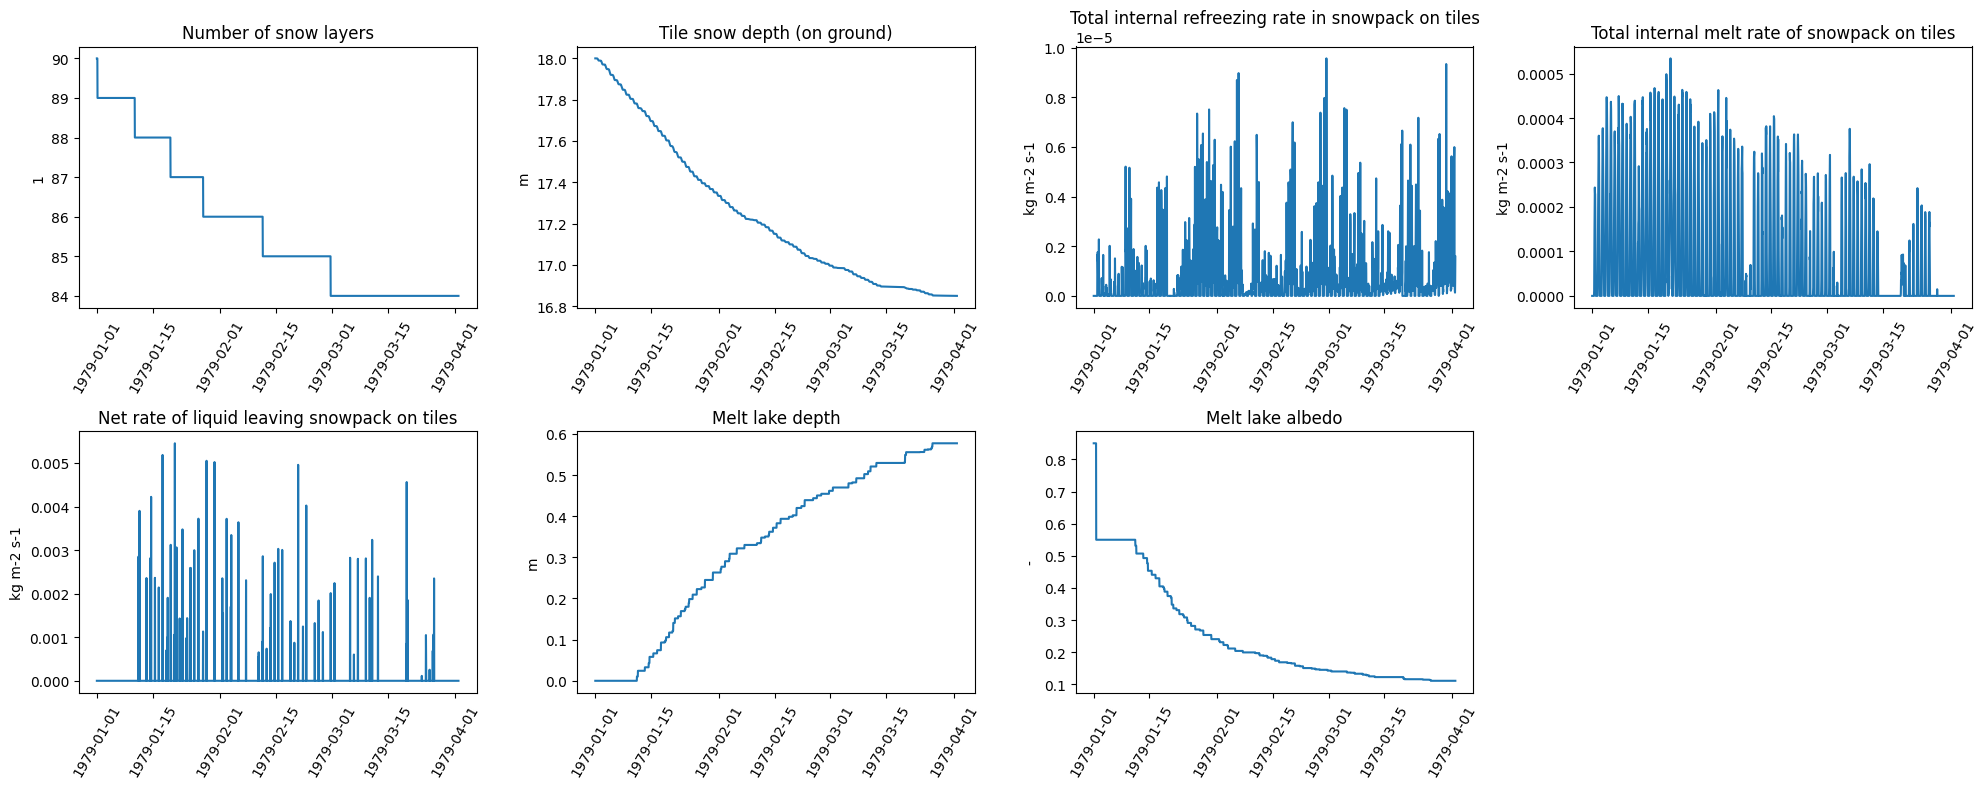

In [11]:
# plot all vars with dimensiosn (time, tile, y, x)

#tile_vars = [v for v in output.variables if output.variables[v].dimensions == ('time', 'tile', 'y', 'x')]

tile_vars = ['nsnow','snow_depth','snice_freez_surft','snice_m_surft', 'snice_runoff_surft','lake_depth_ml','lake_albedo_ml']

# gridded subplots
fig, axes = plt.subplots(-(-len(tile_vars) // 4), 4, figsize=(20, 4 * ((len(tile_vars) + 3) // 4)))

# column subplots 
#fig, axes = plt.subplots(len(tile_vars), 1, figsize=(12, 3 * len(tile_vars)))

axes = axes.flat

for ax, v in zip(axes, tile_vars):
    data = output[v][1:-1, 8, 0, 0]
    
    units = getattr(output[v], 'units', '')    
    time = pd.date_range(start=start_time, periods=len(data), freq='h')

    if v == 'tstar':
        data -= 273.15
        units = '$^oC$'
        
    ax.plot(time, data)
    ax.set_title(getattr(output[v], 'long_name', v))
    ax.set_ylabel(units)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    
    ax.tick_params(axis='x', rotation=60)

for ax in axes[len(tile_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
snice_runoff_surft(i,n) = con_rain(i) + ls_rain(i)  + snice_m_surft(i,n) - snice_freez_surft(i,n) - snice_sliqrate_surft(i,n) <------------------ kgm-2s-1

rate of liq leaving snowpack = con rain + ls rain + melt rate - internal refreezing rate - rate of change of liquid in snowpack   

lake_depth_ml(i,n) = lake_depth_ml(i,n) + (snice_runoff_surft(i,n)  * timestep) / rho_water

lake_albedo_ml(i,n) = (9702.0 + 1000.0 * EXP(3.6 * lake_depth_ml(i,n))) / (-539.0 + 20000.0 * EXP(3.6 * lake_depth_ml(i,n)))

In [ ]:
Qu: 
1. Can I get a lake with realistic initial snowpack temp forcings ?
2. 